This notebook contains the experiments for the case where model have access to initial web context. Here we try to have the models come up with novel search queries during the debate for disambiguation of their argument.

In [1]:
import sys
sys.path.append('..')

import argparse
import torch

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

import requests
from PIL import Image
import json
from transformers import TextStreamer

from utils.data import get_data, show_data
from utils.prompts import initial_prompt_with_context, round1_prompt, debate_prompt
from utils.external_retrieval import get_query_answer

In [2]:
MODEL_NAME = "liuhaotian/llava-v1.6-34b"
temperature = 0.2
max_new_tokens = 512
num_models = 2
models = []

disable_torch_init()

model_name = get_model_name_from_path(MODEL_NAME)
for i in range(num_models):
    tokenizer, model, image_processor, context_len = load_pretrained_model(MODEL_NAME, model_base=None, model_name=model_name, load_8bit=False, load_4bit=False, device_map="auto",
                                                                           max_memory={2:"46068MiB",3:"46068MiB",4:"46068MiB",5:"46068MiB",6:"46068MiB",7:"46068MiB"})
    models.append({"tokenizer":tokenizer, "model":model, "image_processor":image_processor, "context_len":context_len})

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assi

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

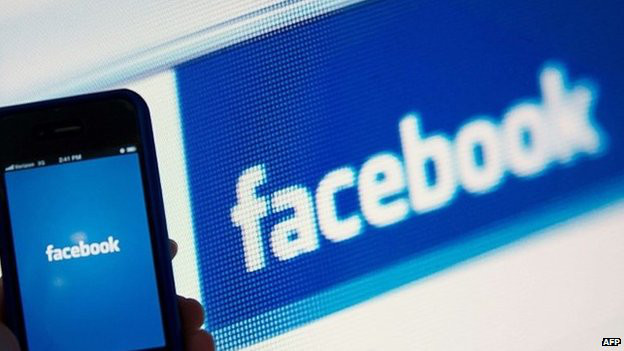

Caption:  In recent years Indian authorities have been criticised for acting against several people for their posts on Facebook or Twitter
Misinformation (Ground Truth): False


In [83]:
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

conv = []
roles = []

for i in range(num_models):
    conv.append(conv_templates[conv_mode].copy())
    if "mpt" in model_name.lower():
        roles.append(('user', 'assistant'))
    else:
        roles.append(conv[i].roles)

data_idx = 74
image, caption, img_path, data_annotation = get_data(data_idx)
display(image)
show_data(data_idx)
image_size = image.size

# Similar operation in model_worker.py
image_tensor = process_images([image], models[0]['image_processor'], models[0]['model'].config)
if type(image_tensor) is list:
    image_tensor = [image.to(models[0]['model'].device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(models[0]['model'].device, dtype=torch.float16)


In [84]:
def generate_output(i, conv, models, image_tensor, temperature, image_size, max_new_tokens):
    print("AGENT - {}: ".format(i+1))
    prompt = conv[i].get_prompt()

    input_ids = tokenizer_image_token(prompt, models[i]['tokenizer'], IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(models[i]['model'].device)
    stop_str = conv[i].sep if conv[i].sep_style != SeparatorStyle.TWO else conv[i].sep2
    keywords = [stop_str]
    streamer = TextStreamer(models[i]['tokenizer'], skip_prompt=True, skip_special_tokens=True)

    with torch.inference_mode():
        output_ids = models[i]['model'].generate(
            input_ids,
            images=image_tensor,
            image_sizes=[image_size],
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            streamer=streamer,
            use_cache=True)

    outputs = models[i]['tokenizer'].decode(output_ids[0]).strip()
    return outputs

def retrieve_summary(key):
    with open("../utils/summaries.json", "r") as f:
        data = json.load(f)
    return data[key]

In [85]:
def initial_prompt_actor(role, text, summary):
    prompt = """{}: This is a summary of text related to the image taken from a news article: {}
Based on this summary and the image provided, you need to determine if the caption given below is being used in a way that's consistent with the context of the news article, or if it's being used to spread false information and mislead people.
CAPTION: {}
Note that the image itself is real and has not been digitally altered. It is taken from a genuine news article.
Carefully examine the image for any known entities, people, watermarks, dates, landmarks, flags, text, logos, and other details which could provide important contextual information.
Your task is to assess whether the image-caption pair, when considered alongside the article summary, presents accurate information or if it's being used in a misleading way. Consider the following:

1. Does the caption align with the overall context of the article summary?
2. Even if the caption doesn't directly describe the image, does it relate to the broader story or event being discussed?
3. Is the image being used in a way that's relevant to the article's content?

Explain your reasoning in detail, considering all aspects of the information provided.
At the end of your analysis, provide a definite YES or NO answer to this question: IS THIS MISINFORMATION?
Remember: In news articles, captions often don't exactly describe the image (but are still related to the image) but are contextually related to the broader story. Focus on whether the image-caption pair, in conjunction with the article summary, presents an accurate representation of the news event or topic.
                    """.format(role, summary, text)
    return prompt

In [86]:
def initial_prompt_skeptic(role, actor_response):
    prompt = """{}: You are a highly skeptical AI agent tasked with critically evaluating responses and uncovering potential flaws or inconsistencies. Your goal is to formulate a single, targeted question that challenges or clarifies the reasoning presented.
Context: An agent was given an image from a news article along with a caption. Their task was to determine if the caption genuinely belongs to the image and news article, or if it's being used to spread misinformation. Here's their response:
{}
Your task:

Carefully analyze the given response for any potential logical flaws, unsupported assumptions, or areas lacking clarity.
Identify the most crucial aspect of the response that requires further scrutiny or elaboration.
Formulate ONE specific, probing question that directly addresses this aspect.

Your question should:

Be directly related to the details or reasoning provided in the response
Target any ambiguities, inconsistencies, or potential weaknesses in the argument
Aim to reveal any gaps in logic or prompt the agent to provide additional evidence for their claims
Be precise and focused, avoiding broad or general inquiries
Should NOT make up scenarios such as "if .."

Remember, your role is not to determine if the original assessment is correct or incorrect, but to challenge the reasoning process and push for greater clarity and depth of analysis.
                """.format(role, actor_response)
    return prompt

In [87]:
def refine_response_prompt(role, text):
    prompt = """ {}: I am skeptical of what your response. Here is what I have to say: {}. 
                Based on my apprehensions, do you still think you are correct? 
                If required, correct yourself, otherwise refine your response to be more detailed.
                Answer any questions/apprehensions I have and refine your response. 
                At the end give a definite YES or NO answer to this question: IS THIS MISINFORMATION?
                Here is some information to keep in mind before answering: 
                        1. the caption often goes well with news articles and can be only contextually related to the image
                        2. the image and caption only need to be contextually related and agree with the general content of the article
            """.format(role, text)
    return prompt

In [88]:
def end_decision_prompt(role, text):
    prompt = """{}: I took into account your skepticism and refined my response: {}
            If you think this response sufficiently and correctly answers the question: IS THIS MISINFORMATION?
            then output 'END' otherwise output 'CONTINUE'.
            """.format(role, text)
    return prompt

In [89]:
def retrieve_stored_url(key, file_path="../utils/retrieval_urls.json"):
    with open(file_path, 'r') as f:
        data = json.load(f)
    urls = data[key]
    return urls

In [90]:
temperature = 0.2
max_new_tokens = 512
num_models = 2
num_rounds = 2

In [ ]:
search_result = ""
search_done = False
summary_key = str(data_annotation['id'])+"_"+str(data_annotation["image_id"])
context = retrieve_summary(summary_key)
print("CONTEXT: \n\n", context)
image_size = image.size
queries = {0:"", 1:""}
temp = ""
num_passes = 0
model_responses = {}
for i in range(num_models):
    model_responses[i] = {"falsified":"", "output":""}
actor_inp = initial_prompt_actor(roles[0][0], caption, context)
if image is not None:
    # first message
    if models[0]['model'].config.mm_use_im_start_end:
        actor_inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + actor_inp
    else:
        actor_inp = DEFAULT_IMAGE_TOKEN + '\n' + actor_inp

conv[0].append_message(conv[0].roles[0], actor_inp)
conv[0].append_message(conv[0].roles[1], None)
actor_outputs = generate_output(0, conv, models, image_tensor, temperature, image_size, max_new_tokens)
conv[0].messages[-1][-1] = actor_outputs

while num_passes != 3:
    skeptic_inp = initial_prompt_skeptic(roles[1][0], actor_outputs)
    if image is not None:
        # first message
        if models[1]['model'].config.mm_use_im_start_end:
            skeptic_inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + skeptic_inp
        else:
            skeptic_inp = DEFAULT_IMAGE_TOKEN + '\n' + skeptic_inp
        image = None
    conv[1].append_message(conv[1].roles[0], skeptic_inp)
    conv[1].append_message(conv[1].roles[1], None)
    skeptic_outputs = generate_output(1, conv, models, image_tensor, temperature, image_size, max_new_tokens)
    conv[1].messages[-1][-1] = skeptic_outputs

    actor_inp = refine_response_prompt(roles[0][0], skeptic_outputs)
    if image is not None:
        # first message
        if models[0]['model'].config.mm_use_im_start_end:
            actor_inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + actor_inp
        else:
            actor_inp = DEFAULT_IMAGE_TOKEN + '\n' + actor_inp

    conv[0].append_message(conv[0].roles[0], actor_inp)
    conv[0].append_message(conv[0].roles[1], None)
    actor_outputs = generate_output(0, conv, models, image_tensor, temperature, image_size, max_new_tokens)
    conv[0].messages[-1][-1] = actor_outputs

    skeptic_inp = end_decision_prompt(roles[1][0], actor_outputs)
    if image is not None:
        # first message
        if models[1]['model'].config.mm_use_im_start_end:
            skeptic_inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + skeptic_inp
        else:
            skeptic_inp = DEFAULT_IMAGE_TOKEN + '\n' + skeptic_inp
        image = None
    conv[1].append_message(conv[1].roles[0], skeptic_inp)
    conv[1].append_message(conv[1].roles[1], None)
    skeptic_outputs = generate_output(1, conv, models, image_tensor, temperature, image_size, max_new_tokens)
    conv[1].messages[-1][-1] = skeptic_outputs
    if 'END' in skeptic_outputs:
        break
    else:
        num_passes += 1
        continue
